In [101]:
import pandas as pd
import os
import seaborn as sns

# ? Se usa para generar gráficos
import matplotlib.pyplot as plt

# ? Se usa para determina la fecha de ejecución del proceso dentro del export de los resultados estadísticos
from datetime import datetime

# ? Conexión a BD Postgres. Se usa dado que pandas no acepta sino este paquete para la conexión.
from sqlalchemy import create_engine, text

from datetime import datetime

from arcgis.features import GeoAccessor, GeoSeriesAccessor
import arcpy

from pathlib import Path

<h3>Credenciales BCGS Alfanumérica</h3>

In [102]:
# """
#     Usuario: vigente
#     Clave: tDL!cg!ZhKRRE2iC9U6Z2#nY

#     Usuario: version
#     Clave: iM#eZzqRnqy$*!2GFDZGtbW8

#     Usuario: historico
#     Clave: y8QwxJ6GC4#AXPkcAYpa@%Y$

#     Usuario: bpmcat
#     Clave: hXtcMJ53Cm*$%Tfz%b4eYURb
# """

In [103]:
arcpy.env.overwriteOutput = True

In [104]:

# ? Se parametrizan las variables a usar en la función de conexión (connect)
host = 'bcgs-multiproposito-rds-alfa-replica.c108sqqsuwz4.us-east-1.rds.amazonaws.com'
database = 'bcgs'
user = 'vigente'
password = 'tDL!cg!ZhKRRE2iC9U6Z2#nY'
port = '5432'
schema = 'bpmcat'

consulta_3 = """
    SELECT municipio as "Municipio" 
        ,(case when vr_nombre_proceso like 'Comple%%' then 'Actualización'
            when vr_nombre_proceso like 'Forma%%' then 'Actualización'
            when vr_nombre_proceso like 'Muta%%' then 'Conservación'				
            when vr_nombre_proceso like 'Recti%%' then 'Conservación'
            else vr_nombre_proceso
            end) "Proceso"
        ,CAST(fecha_radicado AS DATE) AS "Fecha_Radicado"
    FROM vw_rpt_tramites_en_proceso;
"""

consulta_1 = """ 
    select t1.municipio
        ,t1.npn
        ,t1.nro_ficha
        ,t1.radicado
        ,(case when t1.vr_nombre_proceso like 'Comple%%' then 'Actualización'
            when t1.vr_nombre_proceso like 'Forma%%' then 'Actualización'
            when t1.vr_nombre_proceso like 'Muta%%' then 'Conservación'				
            when t1.vr_nombre_proceso like 'Recti%%' then 'Conservación'
            else t1.vr_nombre_proceso
            end) "Proceso"
        ,t1.vr_nombre_proceso	
        ,t1.estado_tramite
        ,t1.actividad
        ,t1.vr_estado_paso
        ,t2.vr_adt_usrins
        ,cast(t1.fecha_radicado as date) fecha_radicado
        ,t1.usuario
        ,cast(t2.dt_adt_fchupd as date) fecha_actualizacion_tramite
        ,t4.vr_task_nom nombre_tarea
        ,t4.vr_task_con 
        ,t4.vr_task_est tarea_estado
        ,(cast(t2.dt_adt_fchupd as date) - cast(t1.fecha_radicado as date)) vida_tramite
        ,(cast(now() as date) - cast(t1.fecha_radicado as date)) vigente_tramite_desde
    from vw_rpt_tramites_en_proceso t1 
    inner join tb_bpm_egn_proegn t2 on t1.radicado = t2.vr_proegn_rad
    inner join tb_bpm_mdl_proces t3 on t2.nb_proces_idn = t3.nb_proces_idn
    inner join tb_bpm_mdl_task t4 on t3.nb_task_idn = t4.nb_task_idn;
"""

try:
    print("Inicio de la conexión")
    
    # ? Se asigna a una variable los resultados de leer una consulta SQL con una conexión previamente generada
    # ? Parámetros de conexión desde sqlalchemy
    url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
    engine = create_engine(url, pool_size=50, echo=False)

    # ? Asignnación de una conexión a una variable
    conexion_sqlalq = engine.connect()

    # Establecer el esquema en la conexión
    conexion_sqlalq.execute(text(f'SET search_path TO {schema}'))

    # TODO: Indicador 1
    # ? Generación de Dataframe por medio de consulta en sql. Función read_sql_query.
    consulta_sql_1 = pd.read_sql_query(consulta_1, conexion_sqlalq)

    # TODO: Indicador 3
    # ? Generación de Dataframe por medio de consulta en sql. Función read_sql_query.
    consulta_sql_3 = pd.read_sql_query(consulta_3, conexion_sqlalq)

    # TODO: Indicador 1
    # ? Se construye el dataframe a partir de la lectura de la consulta (usando la función read_sql_query)
    df_consulta_indicador_1 = pd.DataFrame(consulta_sql_1)
    
    # TODO: Indicador 3
    # ? Se construye el dataframe a partir de la lectura de la consulta (usando la función read_sql_query)
    df_consulta_indicador_3 = pd.DataFrame(consulta_sql_3)

    print("Conexión exitosa ...")
    
    # Cierre de la conexión
    conexion_sqlalq.close()

except Exception as e:
    print(f"Error durante la conexión o ejecución de la consulta: {e}")
    consulta_sql_1 = None
    consulta_sql_3 = None

# Verificar si consulta_sql_3 se definió correctamente
if consulta_sql_1 is not None or consulta_sql_3 is not None:
    print(consulta_sql_1, consulta_sql_3)
else:
    print("La consulta no se pudo ejecutar y la variable consulta_sql_3 no se definió.")

Inicio de la conexión
Conexión exitosa ...
         municipio                             npn nro_ficha radicado  \
0     SABANAGRANDE  086340001000000000036000000000    200025     2684   
1          BARANOA  080780100000005450019000000000    221264     2674   
2          BARANOA  080780100000005710001000000000    221654     2673   
3    MARÍA LA BAJA  134420100000000040001000000000    231171     2676   
4          BARANOA  080780004000000000529000000000    211603     2677   
..             ...                             ...       ...      ...   
185        BARANOA  080780003000000000383000000000    210993     2853   
186   SABANAGRANDE  086340100000000740002000000000    202048     2856   
187        REPELÓN                            None      None     2898   
188  MARÍA LA BAJA  134420100000002590001000000000    234352     2847   
189  MARÍA LA BAJA  134420100000003200001000000000    235114     2848   

           Proceso                                  vr_nombre_proceso  \
0    Ac

<h3>Espacialización de Terrenos</h3>

In [105]:
RUTA_BD_CONSOLIDADA = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E1_Alistamiento_Diagnostico\3_Disposicion\1.BD_Consolidada\BD_Consolidada_Lote4.gdb"

CAPA_TERRENOS_R = 'Analitica_UT_Consolidada\R_TERRENO'
CAPA_TERRENOS_U = 'Analitica_UT_Consolidada\\U_TERRENO'

capa_terrenos_rurales = os.path.join(RUTA_BD_CONSOLIDADA, CAPA_TERRENOS_R)
capa_terrenos_urbanos = os.path.join(RUTA_BD_CONSOLIDADA, CAPA_TERRENOS_U)

# ** Terrenos Rurales
df_terreno_rural = pd.DataFrame.spatial.from_featureclass(capa_terrenos_rurales)
# ** Terrenos Urbanos
df_terreno_urbano = pd.DataFrame.spatial.from_featureclass(capa_terrenos_urbanos)

# ** Selección de columnas
columnas_selecciones = ['CODIGO',
    'CODIGO_ANTERIOR',
    'SHAPE']

# ** DF Terrenos Rurales, Urbanos
df_terreno_rural_reducido = df_terreno_rural[columnas_selecciones]
df_terreno_urbano_reducido = df_terreno_urbano[columnas_selecciones]

# ** Concatenación de dataframes
df_terrenos = pd.concat([df_terreno_rural_reducido, df_terreno_urbano_reducido])

In [106]:
df_estructurado_indicador_graficos_x_proceso = df_consulta_indicador_3['Proceso'].value_counts().reset_index().rename(columns={'count':'Total'})

df_estructurado_indicador_graficos_x_municipio_proceso =  pd.DataFrame(df_consulta_indicador_3.groupby(['Municipio','Proceso'])['Proceso'].count())

df_estructurado_indicador_graficos_x_municipio_proceso.rename(columns={'Proceso':'Total'}, inplace=True)
df_estructurado_indicador_graficos_x_municipio_proceso.reset_index(inplace=True)


In [107]:
columnas_renombrar = {'Fecha_Radicado':'Borrar_1',
    'Municipio':'Borrar_2',
    'Proceso':'Total',
    'Total':'Borrar_3'}

# ** Agrupación y Conteo de Procesos por Fecha y por Tipo de Proceso
df_estructurado_indicador_graficos_x_mpio = pd.DataFrame(df_consulta_indicador_3.groupby(['Fecha_Radicado','Municipio','Proceso'])['Proceso'].count(), columns=['Fecha_Radicado', 'Municipio', 'Proceso','Total'])

# ** Se renombran columnas resultantes, vacías por la operación que se genera
df_estructurado_indicador_graficos_x_mpio.rename(columns = columnas_renombrar, inplace = True)

# ** Lo anterior se realizó para poder resetear el índice y que no se generara error por duplicidad en el nombre de las columnas
df_estructurado_indicador_graficos_x_mpio.reset_index(inplace=True)

# ** Se estandariza el DF con la información necesaria
df_estructurado_indicador_graficos_x_mpio = df_estructurado_indicador_graficos_x_mpio.loc[:,['Fecha_Radicado','Municipio','Proceso','Total']]

print(f"Suma de trámites: {sum(df_estructurado_indicador_graficos_x_mpio['Total'])}")

Suma de trámites: 190


In [108]:

nombre_municipio = 'MARÍA LA BAJA'
query = "Municipio == " + "'"+nombre_municipio+"'"
df_indicador_3_maria_la_baja = df_estructurado_indicador_graficos_x_mpio.query(query)

nombre_municipio = 'REPELÓN'
query = "Municipio == " + "'"+nombre_municipio+"'"
df_indicador_3_repelon = df_estructurado_indicador_graficos_x_mpio.query(query)

nombre_municipio = 'BARANOA'
query = "Municipio == " + "'"+nombre_municipio+"'"
df_indicador_3_baranoa = df_estructurado_indicador_graficos_x_mpio.query(query)

nombre_municipio = 'SABANAGRANDE'
query = "Municipio == " + "'"+nombre_municipio+"'"
df_indicador_3_sabanagrande = df_estructurado_indicador_graficos_x_mpio.query(query)

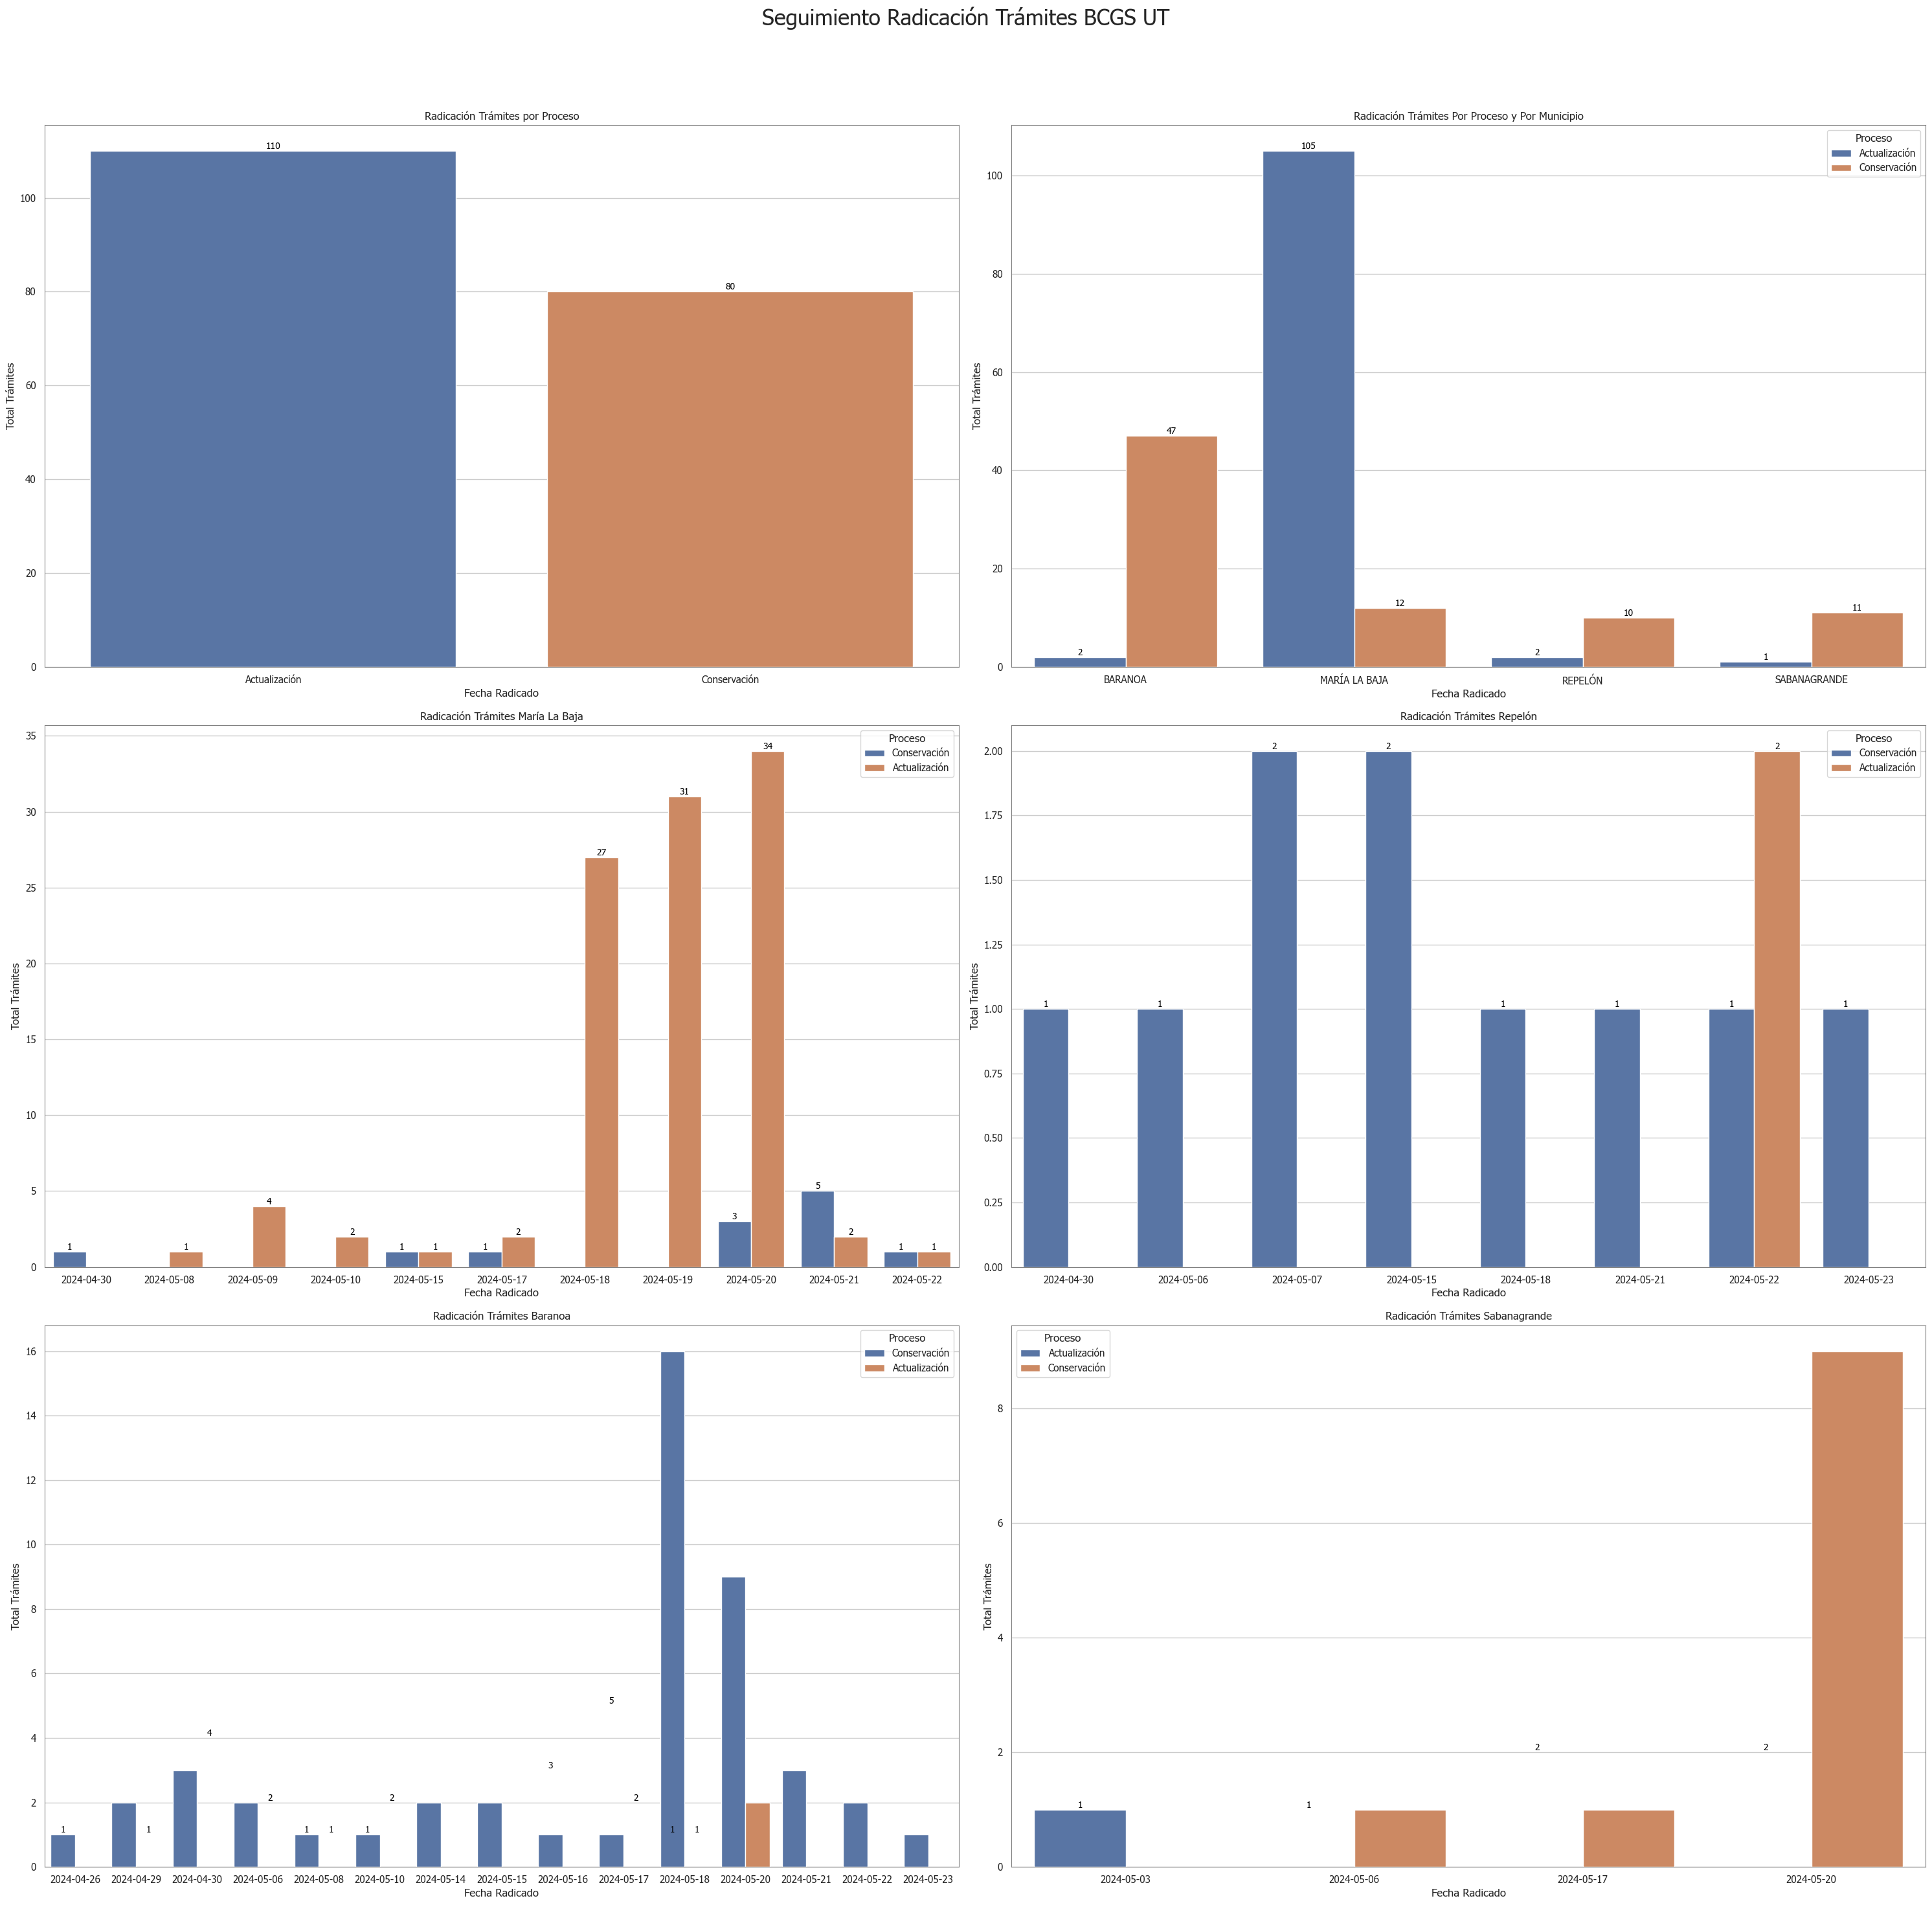

In [109]:

# ** Aplicar tema a la salida gráfica y tipo de texto y tamaño del texto
sns.set_theme(style='whitegrid', font='Tahoma', font_scale=1)

# ** Configuración ejes horizontales en Matplotlib
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.edgecolor'] = 'gray'
plt.rcParams['axes.linewidth'] = 0.8

# ** Se configura el marco de las salidas gráficas (matriz de 2 x 2)
fig, ax = plt.subplots(3, 2, figsize=(30, 30))

# ** Creación de gráficos de barras por Municipio
sns.barplot(ax=ax[0,0], data=df_estructurado_indicador_graficos_x_proceso, x='Proceso', y='Total', errorbar=None)
sns.barplot(ax=ax[0,1], data=df_estructurado_indicador_graficos_x_municipio_proceso, x='Municipio', y='Total', hue='Proceso', errorbar=None)
sns.barplot(ax=ax[1,0], data=df_indicador_3_maria_la_baja, x='Fecha_Radicado', y='Total', hue='Proceso', errorbar=None)
sns.barplot(ax=ax[1,1], data=df_indicador_3_repelon, x='Fecha_Radicado', y='Total', hue='Proceso', errorbar=None)
sns.barplot(ax=ax[2,0], data=df_indicador_3_baranoa, x='Fecha_Radicado', y='Total', hue='Proceso', errorbar=None)
sns.barplot(ax=ax[2,1], data=df_indicador_3_sabanagrande, x='Fecha_Radicado', y='Total', hue='Proceso', errorbar=None)


# ** Etiquetas de Barras
for container in ax[0,0].containers:
    ax[0,0].bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

for container in ax[0,1].containers:
    ax[0,1].bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

for container in ax[1,0].containers:
    ax[1,0].bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

for container in ax[1,1].containers:
    ax[1,1].bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

for container in ax[1,0].containers:
    ax[2,0].bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

for container in ax[1,1].containers:
    ax[2,1].bar_label(container, fmt='%d', label_type='edge', fontsize=10, color='black')

# ** Títulos
# Título general para toda la figura
fig.suptitle('Seguimiento Radicación Trámites BCGS UT', fontsize=24)

ax[0,0].set_title("Radicación Trámites por Proceso")
ax[0,0].set_ylabel("Total Trámites")
ax[0,0].set_xlabel("Fecha Radicado")

ax[0,1].set_title("Radicación Trámites Por Proceso y Por Municipio")
ax[0,1].set_ylabel("Total Trámites")
ax[0,1].set_xlabel("Fecha Radicado")

ax[1,0].set_title("Radicación Trámites María La Baja")
ax[1,0].set_ylabel("Total Trámites")
ax[1,0].set_xlabel("Fecha Radicado")

ax[1,1].set_title("Radicación Trámites Repelón")
ax[1,1].set_ylabel("Total Trámites")
ax[1,1].set_xlabel("Fecha Radicado")

ax[2,0].set_title("Radicación Trámites Baranoa")
ax[2,0].set_ylabel("Total Trámites")
ax[2,0].set_xlabel("Fecha Radicado")

ax[2,1].set_title("Radicación Trámites Sabanagrande")
ax[2,1].set_ylabel("Total Trámites")
ax[2,1].set_xlabel("Fecha Radicado")

plt.tight_layout(rect=[0, 0, 1, 0.95])

<h3>Estado del proceso</h3>

In [110]:
query_actualizacion = "Proceso == 'Actualización'"
query_conservacion = "Proceso == 'Conservación'"

# TODO: Total por estado
df_consulta_indicador_1_actualizacion = df_consulta_indicador_1.query(query_actualizacion)
df_consulta_indicador_1_actualizacion_estado = pd.DataFrame(df_consulta_indicador_1_actualizacion['vr_estado_paso'].value_counts()).rename(columns={'count':'total_estado'}).reset_index().rename(columns={'vr_estado_paso':'estado'})

df_consulta_indicador_1_conservacion = df_consulta_indicador_1.query(query_conservacion)
df_consulta_indicador_1_conservacion_estado = pd.DataFrame(df_consulta_indicador_1_conservacion['vr_estado_paso'].value_counts()).rename(columns={'count':'total_estado'}).reset_index().rename(columns={'vr_estado_paso':'estado'})

# TODO: Total por estado y municipio
df_consulta_indicador_1_actualizacion_estado_municipio = pd.DataFrame(df_consulta_indicador_1_actualizacion[['municipio','vr_estado_paso']].value_counts()).rename(columns={'count':'total_estados'}).reset_index().rename(columns={'vr_estado_paso':'estado'})
df_consulta_indicador_1_conservacion_estado_municipio = pd.DataFrame(df_consulta_indicador_1_conservacion[['municipio','vr_estado_paso']].value_counts()).rename(columns={'count':'total_estados'}).reset_index().rename(columns={'vr_estado_paso':'estado'})



<h3>Estado (En Atención) y Proceso</h3>

In [111]:
query_actualizacion_estado = "Proceso == 'Actualización' and vr_estado_paso == 'ATENDIENDO'"
query_conservacion_estado = "Proceso == 'Conservación' and vr_estado_paso == 'ATENDIENDO'"

# TODO: Total por estado y proceso
df_consulta_indicador_1_actualizacion_estado = df_consulta_indicador_1.query(query_actualizacion_estado)
df_consulta_indicador_1_actualizacion_estado_proceso = pd.DataFrame(df_consulta_indicador_1_actualizacion_estado['vr_nombre_proceso'].value_counts()).rename(columns={'count':'total_procesos'}).reset_index().rename(columns={'vr_nombre_proceso':'nombre_proceso'})

df_consulta_indicador_1_conservacion_estado = df_consulta_indicador_1.query(query_conservacion_estado)
df_consulta_indicador_1_conservacion_estado_proceso = pd.DataFrame(df_consulta_indicador_1_conservacion_estado['vr_nombre_proceso'].value_counts()).rename(columns={'count':'total_procesos'}).reset_index().rename(columns={'vr_nombre_proceso':'nombre_proceso'})

# TODO: Total por proceso y municipio
df_consulta_indicador_1_actualizacion_estado_municipio = pd.DataFrame(df_consulta_indicador_1_actualizacion_estado[['municipio','vr_nombre_proceso']].value_counts()).rename(columns={'count':'total_procesos'}).reset_index().rename(columns={'vr_nombre_proceso':'proceso'})
df_consulta_indicador_1_conservacion_estado_municipio = pd.DataFrame(df_consulta_indicador_1_conservacion_estado[['municipio','vr_nombre_proceso']].value_counts()).rename(columns={'count':'total_procesos'}).reset_index().rename(columns={'vr_nombre_proceso':'proceso'})

<h3>Responsables de tramites en atención</h3>

In [112]:
RUTA_XLSX = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuirica\1.Indicadores_Estrategicos\1.1.Responsable_Por_Tramite_Activo"
fecha_indicador = str(datetime.now().strftime("%Y-%m-%d"))
nombre_xlsx = str(fecha_indicador)+'.xlsx'
ruta_xlsx = os.path.join(RUTA_XLSX, nombre_xlsx)
NOMBRE_HOJA = 'Rendimientos'

df_consulta_indicador_1_actualizacion_estado_responsable = pd.DataFrame(df_consulta_indicador_1_actualizacion_estado['usuario'].value_counts()).rename(columns={'count':fecha_indicador}).reset_index()
df_consulta_indicador_1_actualizacion_estado_responsable.to_excel(ruta_xlsx, sheet_name=NOMBRE_HOJA)
print(f"Se exporta XSLX {nombre_xlsx}")

Se exporta XSLX 2024-05-23.xlsx


<h3>Trámites sin referencia de npn y ficha</h3>

In [113]:
df_consulta_indicador_1

,municipio,npn,nro_ficha,radicado,Proceso,vr_nombre_proceso,estado_tramite,actividad,vr_estado_paso,vr_adt_usrins,fecha_radicado,usuario,fecha_actualizacion_tramite,nombre_tarea,vr_task_con,tarea_estado,vida_tramite,vigente_tramite_desde
0,SABANAGRANDE,086340001000000000036000000000,200025,2684,Actualización,"Complementación - Nomenclatura, Matrícula y Pr...",Revisión Preliminar Jurídica,Revisión preliminar,ATENDIENDO,viannys.lanza,2024-05-03,rodrigo.ponce,2024-05-03,inicio,None,None,0,20
1,BARANOA,080780100000005450019000000000,221264,2674,Conservación,Mutaciones de Primera Clase,Verificando información,Revisión preliminar cambio de poseedor u ocupante,ATENDIENDO,erick.racedo,2024-04-29,rodrigo.ponce,2024-04-29,inicio,None,None,0,24
2,BARANOA,080780100000005710001000000000,221654,2673,Conservación,Mutaciones de Segunda Clase,Realizando reconocimiento predial,Reconocimiento Predial,ATENDIENDO,erick.racedo,2024-04-26,melany.delahoz,2024-04-29,inicio,None,None,3,27
3,MARÍA LA BAJA,134420100000000040001000000000,231171,2676,Conservación,Mutaciones de Primera Clase,En verificación de documentos,Recibir y verificar requisitos,ATENDIENDO,geovany.estarita,2024-04-30,geovany.estarita,2024-04-30,inicio,None,None,0,23
4,BARANOA,080780004000000000529000000000,211603,2677,Conservación,Mutaciones de Segunda Clase,Revisando Preliminar,Revisión preliminar,ATENDIENDO,erick.racedo,2024-04-30,rodrigo.ponce,2024-04-30,inicio,None,None,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,BARANOA,080780003000000000383000000000,210993,2853,Conservación,Mutaciones de Segunda Clase,Revisando Preliminar,Revisión preliminar,ATENDIENDO,erick.racedo,2024-05-20,rodrigo.ponce,2024-05-22,inicio,None,None,2,3
186,SABANAGRANDE,086340100000000740002000000000,202048,2856,Conservación,Mutaciones de Segunda Clase,En verificación de documentos,Recibir y verificar requisitos,DEVUELTO,miguel.fruto,2024-05-20,miguel.fruto,2024-05-22,inicio,None,None,2,3
187,REPELÓN,None,None,2898,Actualización,Formación y/o Actualización V2,Iniciado,Entregar insumos para contratista,ATENDIENDO,jacqueline.jimenez,2024-05-22,jacqueline.jimenez,2024-05-22,inicio,None,None,0,1
188,MARÍA LA BAJA,134420100000002590001000000000,234352,2847,Actualización,Formación y Actualización,Realizando prepararación de la información en ...,Preparación de Información en Oficina,ATENDIENDO,luis.jimenez,2024-05-20,luis.jimenez,2024-05-20,inicio,None,None,0,3


<h3>Espacialización de trámites</h3>

In [114]:
#df_terrenos

para_espacializacion_tramites = df_consulta_indicador_1[['municipio','radicado','npn','nro_ficha','Proceso','vr_estado_paso']]
para_espacializacion_tramites = para_espacializacion_tramites.dropna()

df_merge_terrenos_espacializacion_tramites = pd.merge(df_terrenos, para_espacializacion_tramites, left_on='CODIGO', right_on='npn', how='inner')
df_merge_terrenos_espacializacion_tramites = (df_merge_terrenos_espacializacion_tramites[['CODIGO','CODIGO_ANTERIOR','nro_ficha','radicado','Proceso','vr_estado_paso','SHAPE']]).rename(columns={'vr_estado_paso':'Estado'})

NOMBRE_FC_TERRENOS_CON_TRAMITES_EN_ATENCION = 'TERRENOS_CON_TRAMITES_EN_ATENCION'

df_merge_terrenos_espacializacion_tramites.spatial.to_featureclass(location=os.path.join(RUTA_BD_CONSOLIDADA,'Analitica_UT_Consolidada\\' + NOMBRE_FC_TERRENOS_CON_TRAMITES_EN_ATENCION))
print(f"Se exporta FC {NOMBRE_FC_TERRENOS_CON_TRAMITES_EN_ATENCION} en BD: {Path(RUTA_BD_CONSOLIDADA).stem}")

BD_TRAMITES_EN_ATENCION = r"C:\docsProyectos\5.RAISS\2024.0.RAISS_Lote_4\6.Hitos\E2_Informes_Id_FisicoJuirica\2.Indicadores_Espacializacion_Tramites\Base_Datos\Terrenos_Tramites.gdb"

df_merge_terrenos_espacializacion_tramites.spatial.to_featureclass(location=os.path.join(BD_TRAMITES_EN_ATENCION,NOMBRE_FC_TERRENOS_CON_TRAMITES_EN_ATENCION))
print(f"Se exporta FC {NOMBRE_FC_TERRENOS_CON_TRAMITES_EN_ATENCION} en BD: {Path(BD_TRAMITES_EN_ATENCION).stem}")

Se exporta FC TERRENOS_CON_TRAMITES_EN_ATENCION en BD: BD_Consolidada_Lote4
Se exporta FC TERRENOS_CON_TRAMITES_EN_ATENCION en BD: Terrenos_Tramites
